<a href="https://colab.research.google.com/github/NaziaHasanDana/DanceWebsite/blob/master/Tabular%20dataset%20to%20graph(Heterogeneous).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Download data (quietly)
!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/anime.csv
!wget -q https://raw.githubusercontent.com/Mayank-Bhatia/Anime-Recommender/master/data/rating.csv

anime = pd.read_csv("anime.csv")
rating = pd.read_csv("rating.csv")

In [4]:
print(anime)

       anime_id                                               name  \
0         32281                                     Kimi no Na wa.   
1          5114                   Fullmetal Alchemist: Brotherhood   
2         28977                                           Gintama°   
3          9253                                        Steins;Gate   
4          9969                                      Gintama&#039;   
...         ...                                                ...   
12289      9316       Toushindai My Lover: Minami tai Mecha-Minami   
12290      5543                                        Under World   
12291      5621                     Violence Gekiga David no Hoshi   
12292      6133  Violence Gekiga Shin David no Hoshi: Inma Dens...   
12293     26081                   Yasuji no Pornorama: Yacchimae!!   

                                                   genre   type episodes  \
0                   Drama, Romance, School, Supernatural  Movie        1   
1      

AttributeError: ignored

In [5]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [10]:
# Sort to define the order of nodes
sorted_df = anime.sort_values(by="anime_id").set_index("anime_id")
sorted_df

# Map IDs to start from 0
sorted_df = sorted_df.reset_index(drop=False)
movie_id_mapping = sorted_df["anime_id"]


In [9]:
# Select node features
node_features = sorted_df[["type", "genre", "episodes"]]


In [11]:
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)

# For simplicity I'll just select the first genre here and ignore the others
genres = node_features["genre"].str.split(",", expand=True)
node_features["main_genre"] = genres[0]

# One-hot encoding
anime_node_features = pd.concat([node_features, pd.get_dummies(node_features["main_genre"])], axis=1, join='inner')
anime_node_features = pd.concat([anime_node_features, pd.get_dummies(anime_node_features["type"])], axis=1, join='inner')
anime_node_features.drop(["genre", "main_genre"], axis=1, inplace=True)
anime_node_features.head(10)

,type,episodes,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Supernatural,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV
0,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Movie,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,TV,52,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,TV,145,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,TV,24,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,TV,52,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,TV,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,TV,74,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
# Convert to numpy
x = anime_node_features.to_numpy()
x.shape # [num_movie_nodes x movie_node_feature_dim]

(12294, 48)

In [13]:
# Find out mean rating and number of ratings per user
mean_rating = rating.groupby("user_id")["rating"].mean().rename("mean")
num_rating = rating.groupby("user_id")["rating"].count().rename("count")
user_node_features = pd.concat([mean_rating, num_rating], axis=1)

# Remap user ID (to start at 0)
user_node_features = user_node_features.reset_index(drop=False)
user_id_mapping = user_node_features["user_id"]

# Only keep features 
user_node_features = user_node_features[["mean", "count"]]
user_node_features.head()

,mean,count
0,-0.712418,153
1,2.666667,3
2,7.382979,94
3,-1.000000,52
4,4.263383,467


In [14]:
# Convert to numpy
x = user_node_features.to_numpy()
x.shape # [num_user_nodes x user_node_feature_dim]

(73515, 2)

In [15]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


<Axes: >

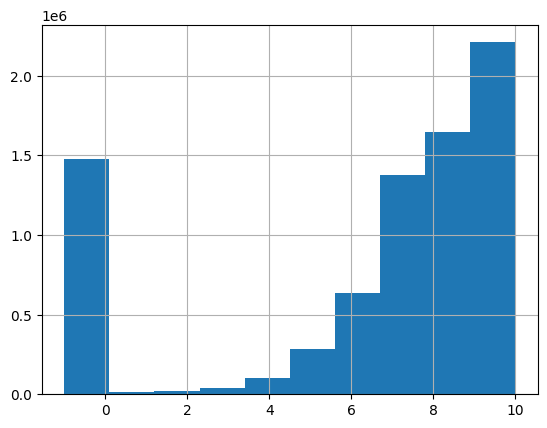

In [16]:
# -1 means the user watched but didn't assign a weight
rating["rating"].hist()

In [17]:
# Movies that are part of our rating matrix
rating["anime_id"].unique()

array([   20,    24,    79, ..., 29481, 34412, 30738])

In [18]:
# All movie IDs (e.g. no rating above for 1, 5, 6...)
anime["anime_id"].sort_values().unique()

array([    1,     5,     6, ..., 34522, 34525, 34527])

In [19]:
# We can also see that there are some movies in the rating matrix, for which we have no features (we will drop them here)
print(set(rating["anime_id"].unique()) - set(anime["anime_id"].unique()))
rating = rating[~rating["anime_id"].isin([30913, 30924, 20261])]

{30913, 30924, 20261}


In [20]:
# Extract labels
labels = rating["rating"]
labels.tail()

7813732     7
7813733     9
7813734    10
7813735     9
7813736     9
Name: rating, dtype: int64

In [21]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(7813727,)

In [22]:
# Map anime IDs 
movie_map = movie_id_mapping.reset_index().set_index("anime_id").to_dict()
rating["anime_id"] = rating["anime_id"].map(movie_map["index"]).astype(int)
# Map user IDs
user_map = user_id_mapping.reset_index().set_index("user_id").to_dict()
rating["user_id"] = rating["user_id"].map(user_map["index"]).astype(int)

print("After remapping...")
rating.head()

After remapping...


,user_id,anime_id,rating
0,0,10,-1
1,0,14,-1
2,0,58,-1
3,0,202,-1
4,0,217,-1


In [23]:
edge_index = rating[["user_id", "anime_id"]].values.transpose()
edge_index # [2 x num_edges] 

array([[    0,     0,     0, ..., 73513, 73514, 73514],
       [   10,    14,    58, ...,  8624,   718,  5226]])

In [24]:
from torch_geometric.data import HeteroData
data = HeteroData()
data['user'].x = user_node_features
data['movie'].x = anime_node_features

ModuleNotFoundError: ignored

In [25]:
pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=4b874790761fad263f71624c2079eac1d839f3aa2daa6b331fe3877a76d4cbcc
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [26]:
from torch_geometric.data import HeteroData
data = HeteroData()
data['user'].x = user_node_features
data['movie'].x = anime_node_features

In [28]:
data['user', 'rating', movie'].edge_index = edge_index

SyntaxError: ignored

In [ ]:
data['user', 'movie'].y = y